In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from keplergl import KeplerGl
from h3 import h3
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
vans_raw = pd.read_csv('vans_fix.csv')
sgs_raw = pd.read_csv('sugerencias_fix.csv')
rsv_raw = pd.read_csv('reservaciones_fix.csv')

In [3]:
vans_raw.head()


,Van,Ruta,Horario,hour,Inventario,Numero de Asientos por Van,Numero de Viajes,¿Viaje activo?
0,C04,Danone CLCN - Culiacán Ida,06:49:00,6.0,340,20,17,True
1,C04,Danone CLCN - Culiacán Ida,14:49:00,14.0,420,20,21,True
2,C04,Danone CLCN - Culiacán Ida,18:49:00,18.0,340,20,17,True
3,C04,Danone CLCN - Culiacán Vuelta,08:15:00,8.0,200,20,10,False
4,C04,Danone CLCN - Culiacán Vuelta,08:15:00,8.0,140,20,7,True


In [4]:
sgs_raw.head()

,Id sugerencia,Fecha sugerencia,week,weekday,Hora sugerencia,hour,Fuente,Client_id,Latitud sugerencia,Longitud sugerencia,...,Colonia destino,Horario de ida,Horario de regreso,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado,Domingo
0,10652,11/04/2021,15,7,23:56,23.0,app,409604.0,NaN,NaN,...,NaN,05:00:00-05,05:00:00-05,False,False,False,False,False,False,False
1,10651,11/04/2021,15,7,23:16,23.0,app,409685.0,NaN,NaN,...,NaN,05:00:00-05,05:00:00-05,False,False,False,False,False,False,False
2,10650,11/04/2021,15,7,23:03,23.0,app,409682.0,NaN,NaN,...,NaN,05:00:00-05,05:00:00-05,False,False,False,False,False,False,False
3,10649,11/04/2021,15,7,22:28,22.0,app,404354.0,NaN,NaN,...,NaN,05:00:00-05,05:00:00-05,False,False,False,False,False,False,False
4,10648,11/04/2021,15,7,22:20,22.0,app,389074.0,NaN,NaN,...,NaN,05:00:00-05,05:00:00-05,False,False,False,False,False,False,False


In [5]:
rsv_raw.head()


,ID viaje,ruta,linea,fecha,weekday,week,hora,hour,ETA,eta_hour,...,rating,Costo total,Semana del año,weekday.1,Red discount,Coupon discount,Costo final,confirmed,Estación de subida,Estación de bajada
0,483896,Toluca - Santa Fe,Toluca - Santa Fe,22/03/2021,1.0,13.0,08:15:00,8.0,09:45:00,9.0,...,NaN,83,2021-12,L,NaN,1,83,True,Lerma outlet,UP Santa Fe
1,496716,CDMX - Querétaro,Querétaro - CDMX,08/04/2021,4.0,15.0,13:00:00,13.0,16:40:00,16.0,...,5.0,185,2021-14,M,NaN,50,185,True,Glorieta de la Palma,Walmart Juriquilla
2,495506,Querétaro - CDMX,Querétaro - CDMX,04/04/2021,7.0,14.0,17:10:00,17.0,20:42:00,20.0,...,5.0,390,2021-13,D,NaN,50,390,True,Walmart Juriquilla,Glorieta de la Palma
3,490841,CDMX - Querétaro,Querétaro - CDMX,31/03/2021,3.0,14.0,10:30:00,10.0,14:06:00,14.0,...,5.0,420,2021-13,M,NaN,50,420,True,Glorieta de la Palma,Walmart Juriquilla
4,490960,CDMX - Querétaro,Querétaro - CDMX,28/03/2021,7.0,13.0,19:15:00,19.0,22:46:00,22.0,...,5.0,420,2021-12,D,NaN,50,420,True,Glorieta de la Palma,Puerta La Victoria


# Data Cleansing

## Vans

In [6]:
#Removing duplicate registers
vans = vans_raw.drop_duplicates()
rsv = rsv_raw.drop_duplicates()
sgs = sgs_raw.drop_duplicates()

In [7]:
#Exploration
vans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2379 entries, 0 to 2378
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Van                         2379 non-null   object 
 1   Ruta                        2379 non-null   object 
 2   Horario                     2379 non-null   object 
 3   hour                        2379 non-null   float64
 4   Inventario                  2379 non-null   int64  
 5   Numero de Asientos por Van  2379 non-null   int64  
 6   Numero de Viajes            2379 non-null   int64  
 7   ¿Viaje activo?              2379 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 151.0+ KB


In [8]:
vans.Ruta.value_counts()#.plot(kind = 'bar', ylim= (0,40))

CDMX - Querétaro                  93
Querétaro - CDMX                  90
CDMX - Tepoztlán - Cuernavaca     49
Cuernavaca - Tepoztlán - CDMX     40
Amazon GDL1 - Chapala Ida         38
                                  ..
Elektra CEDIS - Buenavista Ida     1
Amazon DVR1 - Ruta 1 Ida           1
Moons CDMX - Ruta 3 Vta            1
Opticretos - Ruta 1 Ida            1
Moons - Ruta 2 Vuelta              1
Name: Ruta, Length: 416, dtype: int64

In [9]:
#Statistical metrics
vans.describe()

,hour,Inventario,Numero de Asientos por Van,Numero de Viajes
count,2379.000000,2379.000000,2379.000000,2379.000000
mean,12.121480,113.514502,17.425389,6.597310
std,6.806526,111.768478,3.430035,6.164694
min,0.000000,9.000000,5.000000,1.000000
25%,6.000000,26.000000,13.000000,2.000000
50%,13.000000,70.000000,20.000000,4.000000
75%,18.000000,169.000000,20.000000,11.000000
max,23.000000,780.000000,40.000000,39.000000


## Reservaciones

In [11]:
#Exploration
rsv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11226 entries, 0 to 11225
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID viaje            11226 non-null  int64  
 1   ruta                11226 non-null  object 
 2   linea               11226 non-null  object 
 3   fecha               11226 non-null  object 
 4   weekday             11226 non-null  float64
 5   week                11226 non-null  float64
 6   hora                11226 non-null  object 
 7   hour                11226 non-null  float64
 8   ETA                 11226 non-null  object 
 9   eta_hour            11226 non-null  float64
 10  id_usuario          11226 non-null  int64  
 11  numero_asientos     11226 non-null  int64  
 12  rating              2865 non-null   float64
 13  Costo total         11226 non-null  int64  
 14  Semana del año      11226 non-null  object 
 15  weekday.1           11226 non-null  object 
 16  Red 

In [12]:
#Dropping incomplete columns
rsv.drop('rating', axis = 1, inplace = True )

In [13]:
#Statistical metrics
rsv.describe(include ='all')

,ID viaje,ruta,linea,fecha,weekday,week,hora,hour,ETA,eta_hour,...,numero_asientos,Costo total,Semana del año,weekday.1,Red discount,Coupon discount,Costo final,confirmed,Estación de subida,Estación de bajada
count,11226.000000,11226,11226,11226,11226.000000,11226.000000,11226,11226.000000,11226,11226.000000,...,11226.000000,11226.000000,11226,11226,1860.000000,11226.000000,11226.000000,11226,11226,11226
unique,NaN,121,43,21,NaN,NaN,133,NaN,378,NaN,...,NaN,NaN,5,7,NaN,NaN,NaN,2,276,125
top,NaN,Querétaro - CDMX,Querétaro - CDMX,05/04/2021,NaN,NaN,07:00:00,NaN,05:50:00,NaN,...,NaN,NaN,2021-12,X,NaN,NaN,NaN,True,Auditorio Nacional,Elektra CEDIS - VHSA
freq,NaN,912,1777,730,NaN,NaN,563,NaN,403,NaN,...,NaN,NaN,3973,2088,NaN,NaN,NaN,10562,499,535
mean,492245.882060,NaN,NaN,NaN,3.443969,13.994032,NaN,11.309995,NaN,12.861750,...,1.057100,67.662391,NaN,NaN,19.532796,2.472742,64.426064,NaN,NaN,NaN
std,6046.793184,NaN,NaN,NaN,1.839465,0.839058,NaN,5.745774,NaN,5.954403,...,0.232043,100.412653,NaN,NaN,5.182573,10.809211,100.120398,NaN,NaN,NaN
min,468476.000000,NaN,NaN,NaN,1.000000,13.000000,NaN,0.000000,NaN,0.000000,...,1.000000,0.000000,NaN,NaN,7.000000,0.000000,0.000000,NaN,NaN,NaN
25%,488577.000000,NaN,NaN,NaN,2.000000,13.000000,NaN,6.000000,NaN,8.000000,...,1.000000,0.000000,NaN,NaN,16.000000,0.000000,0.000000,NaN,NaN,NaN
50%,492368.000000,NaN,NaN,NaN,3.000000,14.000000,NaN,11.000000,NaN,13.000000,...,1.000000,0.000000,NaN,NaN,19.000000,0.000000,0.000000,NaN,NaN,NaN
75%,496753.000000,NaN,NaN,NaN,5.000000,15.000000,NaN,17.000000,NaN,19.000000,...,1.000000,107.000000,NaN,NaN,24.000000,0.000000,82.000000,NaN,NaN,NaN


In [14]:
rsv.linea.value_counts()

Querétaro - CDMX                      1777
Elektra - Villahermosa                 954
Avery Dennison CDMX                    805
Hyperion                               732
G4S Querétaro                          698
Mixcoac - Santa Fe                     637
Cuernavaca - CDMX                      539
Zona Sur - Santa Fe                    435
Coacalco - Santa Fe                    417
Toluca - Santa Fe                      415
Zona Norte - Santa Fe                  399
Amazon MTY1 - Pesqueria                360
Amazon DVR1                            348
Empacadora de Embutidos del Centro     280
Amazon MTY1 - Guadalupe                275
Cuau. Izcalli - Santa Fe               253
Computrabajo                           228
Moons                                  210
Bodegas Alianza                        189
Juanacatlán - Santa Fe                 155
Amazon MTY1 - Concordia                148
Amazon MTY1 - Pesquería/Apodaca        147
Atramat Almacén                        146
Amazon DCL1

In [15]:
# Wether it is city or travel
rsv.loc[(rsv.linea == 'Querétaro - CDMX') |(rsv.linea == 'Querétaro - Guadalajara')
        |(rsv.linea == 'Cuernavaca - CDMX')|(rsv.linea == 'Veracruz - Cdmx') 
        |(rsv.linea == 'Toluca - Santa Fe')| (rsv.linea == 'Querétaro - Morelia')
        |(rsv.linea == 'Kavak - Lerma'),'is_city']= 0
rsv.loc[rsv.is_city!= 0,'is_city'] = 1
rsv

,ID viaje,ruta,linea,fecha,weekday,week,hora,hour,ETA,eta_hour,...,Costo total,Semana del año,weekday.1,Red discount,Coupon discount,Costo final,confirmed,Estación de subida,Estación de bajada,is_city
0,483896,Toluca - Santa Fe,Toluca - Santa Fe,22/03/2021,1.0,13.0,08:15:00,8.0,09:45:00,9.0,...,83,2021-12,L,NaN,1,83,True,Lerma outlet,UP Santa Fe,0.0
1,496716,CDMX - Querétaro,Querétaro - CDMX,08/04/2021,4.0,15.0,13:00:00,13.0,16:40:00,16.0,...,185,2021-14,M,NaN,50,185,True,Glorieta de la Palma,Walmart Juriquilla,0.0
2,495506,Querétaro - CDMX,Querétaro - CDMX,04/04/2021,7.0,14.0,17:10:00,17.0,20:42:00,20.0,...,390,2021-13,D,NaN,50,390,True,Walmart Juriquilla,Glorieta de la Palma,0.0
3,490841,CDMX - Querétaro,Querétaro - CDMX,31/03/2021,3.0,14.0,10:30:00,10.0,14:06:00,14.0,...,420,2021-13,M,NaN,50,420,True,Glorieta de la Palma,Walmart Juriquilla,0.0
4,490960,CDMX - Querétaro,Querétaro - CDMX,28/03/2021,7.0,13.0,19:15:00,19.0,22:46:00,22.0,...,420,2021-12,D,NaN,50,420,True,Glorieta de la Palma,Puerta La Victoria,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11221,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,79,2021-12,X,19.0,0,60,True,City Shops,Edificio Telefónica,1.0
11222,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,79,2021-12,X,19.0,0,60,True,City Shops,Samara S.,1.0
11223,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,79,2021-12,X,19.0,0,60,True,Papa Bill's,Office Depot Santa Fe,1.0
11224,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,79,2021-12,M,19.0,0,60,True,City Shops,Samara S.,1.0


In [16]:
rsv.loc[(rsv.weekday == 1) |(rsv.weekday == 2) | (rsv.weekday == 3) |(rsv.weekday == 4) |(rsv.weekday == 5), 'day_type'] = 'weekday'
rsv.loc[rsv.day_type != 'weekday', 'day_type'] = 'weekend'
rsv

,ID viaje,ruta,linea,fecha,weekday,week,hora,hour,ETA,eta_hour,...,Semana del año,weekday.1,Red discount,Coupon discount,Costo final,confirmed,Estación de subida,Estación de bajada,is_city,day_type
0,483896,Toluca - Santa Fe,Toluca - Santa Fe,22/03/2021,1.0,13.0,08:15:00,8.0,09:45:00,9.0,...,2021-12,L,NaN,1,83,True,Lerma outlet,UP Santa Fe,0.0,weekday
1,496716,CDMX - Querétaro,Querétaro - CDMX,08/04/2021,4.0,15.0,13:00:00,13.0,16:40:00,16.0,...,2021-14,M,NaN,50,185,True,Glorieta de la Palma,Walmart Juriquilla,0.0,weekday
2,495506,Querétaro - CDMX,Querétaro - CDMX,04/04/2021,7.0,14.0,17:10:00,17.0,20:42:00,20.0,...,2021-13,D,NaN,50,390,True,Walmart Juriquilla,Glorieta de la Palma,0.0,weekend
3,490841,CDMX - Querétaro,Querétaro - CDMX,31/03/2021,3.0,14.0,10:30:00,10.0,14:06:00,14.0,...,2021-13,M,NaN,50,420,True,Glorieta de la Palma,Walmart Juriquilla,0.0,weekday
4,490960,CDMX - Querétaro,Querétaro - CDMX,28/03/2021,7.0,13.0,19:15:00,19.0,22:46:00,22.0,...,2021-12,D,NaN,50,420,True,Glorieta de la Palma,Puerta La Victoria,0.0,weekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11221,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,2021-12,X,19.0,0,60,True,City Shops,Edificio Telefónica,1.0,weekday
11222,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,2021-12,X,19.0,0,60,True,City Shops,Samara S.,1.0,weekday
11223,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,2021-12,X,19.0,0,60,True,Papa Bill's,Office Depot Santa Fe,1.0,weekday
11224,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,2021-12,M,19.0,0,60,True,City Shops,Samara S.,1.0,weekday


In [18]:
rsv.week.value_counts()

13.0    3985
15.0    3918
14.0    3323
Name: week, dtype: int64

In [19]:
# Drop old date columns
rsv.drop(['Semana del año', 'weekday.1'], axis = 1, inplace= True )
rsv

,ID viaje,ruta,linea,fecha,weekday,week,hora,hour,ETA,eta_hour,...,numero_asientos,Costo total,Red discount,Coupon discount,Costo final,confirmed,Estación de subida,Estación de bajada,is_city,day_type
0,483896,Toluca - Santa Fe,Toluca - Santa Fe,22/03/2021,1.0,13.0,08:15:00,8.0,09:45:00,9.0,...,1,83,NaN,1,83,True,Lerma outlet,UP Santa Fe,0.0,weekday
1,496716,CDMX - Querétaro,Querétaro - CDMX,08/04/2021,4.0,15.0,13:00:00,13.0,16:40:00,16.0,...,1,185,NaN,50,185,True,Glorieta de la Palma,Walmart Juriquilla,0.0,weekday
2,495506,Querétaro - CDMX,Querétaro - CDMX,04/04/2021,7.0,14.0,17:10:00,17.0,20:42:00,20.0,...,2,390,NaN,50,390,True,Walmart Juriquilla,Glorieta de la Palma,0.0,weekend
3,490841,CDMX - Querétaro,Querétaro - CDMX,31/03/2021,3.0,14.0,10:30:00,10.0,14:06:00,14.0,...,2,420,NaN,50,420,True,Glorieta de la Palma,Walmart Juriquilla,0.0,weekday
4,490960,CDMX - Querétaro,Querétaro - CDMX,28/03/2021,7.0,13.0,19:15:00,19.0,22:46:00,22.0,...,2,420,NaN,50,420,True,Glorieta de la Palma,Puerta La Victoria,0.0,weekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11221,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,1,79,19.0,0,60,True,City Shops,Edificio Telefónica,1.0,weekday
11222,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,1,79,19.0,0,60,True,City Shops,Samara S.,1.0,weekday
11223,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,1,79,19.0,0,60,True,Papa Bill's,Office Depot Santa Fe,1.0,weekday
11224,485487,Zona Norte - Santa Fe,Zona Norte - Santa Fe,24/03/2021,3.0,13.0,07:00:00,7.0,08:02:00,8.0,...,1,79,19.0,0,60,True,City Shops,Samara S.,1.0,weekday


## Sugerencias

In [20]:
sgs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067 entries, 0 to 1066
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id sugerencia        1067 non-null   int64  
 1   Fecha sugerencia     1067 non-null   object 
 2   week                 1067 non-null   int64  
 3   weekday              1067 non-null   int64  
 4   Hora sugerencia      1067 non-null   object 
 5   hour                 1067 non-null   float64
 6   Fuente               1067 non-null   object 
 7   Client_id            1011 non-null   float64
 8   Latitud sugerencia   73 non-null     float64
 9   Longitud sugerencia  73 non-null     float64
 10  Latitud origen       1067 non-null   float64
 11  Longitud origen      1067 non-null   float64
 12  Direccion origen     1066 non-null   object 
 13  CP origen            16 non-null     float64
 14  Ciudad origen        56 non-null     object 
 15  Estado origen        56 non-null     o

In [21]:
# Days are filled with false
print(sgs.Lunes.value_counts(),
sgs.Martes.value_counts(),
sgs.Miercoles.value_counts(),
sgs.Jueves.value_counts(),
sgs.Viernes.value_counts(),
sgs.Sabado.value_counts(),
sgs.Domingo.value_counts(), 
sgs.Fuente.value_counts())

False    1011
Name: Lunes, dtype: int64 False    1011
Name: Martes, dtype: int64 False    1011
Name: Miercoles, dtype: int64 False    1011
Name: Jueves, dtype: int64 False    1011
Name: Viernes, dtype: int64 False    1011
Name: Sabado, dtype: int64 False    1011
Name: Domingo, dtype: int64 app    1011
web      56
Name: Fuente, dtype: int64


In [22]:
sgs['Horario de ida'].value_counts()

07:00:00-05    689
05:00:00-05    322
Name: Horario de ida, dtype: int64

In [23]:
sgs['Horario de regreso'].value_counts()

07:00:00-05    689
05:00:00-05    322
Name: Horario de regreso, dtype: int64

In [24]:
sgs.drop(['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 
          'Domingo', 'Colonia destino','Lugar destino', 'Pais destino',
          'Estado destino', 'Ciudad destino',  'CP destino', 
          'Longitud sugerencia','Latitud sugerencia', 'Colonia origen', 
          'Lugar origen','Pais origen', 'Estado origen','Ciudad origen',
          'CP origen', 'Direccion origen', 'Fuente', 'Direccion destino',
          'Horario de ida', 'Horario de regreso'
          
         ], axis = 1, inplace = True)

In [25]:
# Extracting date out of "fecha"
# sgs['fecha_sgs'] = sgs['Fecha sugerencia'].astype('datetime64[ns]')
# sgs['hora_sgs'] = sgs['Hora sugerencia'].astype('datetime64[ns]')
#sgs = sgs.assign (#fecha = sgs['fecha_sgs'].dt.strftime('20%y/%m/%d'), 
                  #hora = sgs['hora_sgs'].dt.strftime('%H'), 
                  #dia_semana =  sgs['fecha_sgs'].dt.strftime('%w'), 
                  #semana = sgs['fecha_sgs'].dt.strftime('%W')
                  
                  
sgs

,Id sugerencia,Fecha sugerencia,week,weekday,Hora sugerencia,hour,Client_id,Latitud origen,Longitud origen,Latitud destino,Longitud destino
0,10652,11/04/2021,15,7,23:56,23.0,409604.0,20.553563,-100.392255,19.288524,-99.622360
1,10651,11/04/2021,15,7,23:16,23.0,409685.0,19.508680,-101.612018,19.987021,-101.280722
2,10650,11/04/2021,15,7,23:03,23.0,409682.0,19.347770,-99.068340,18.924209,-99.221566
3,10649,11/04/2021,15,7,22:28,22.0,404354.0,20.651450,-100.344020,19.355121,-99.276387
4,10648,11/04/2021,15,7,22:20,22.0,389074.0,18.947916,-99.191668,18.946916,-99.190668
...,...,...,...,...,...,...,...,...,...,...,...
1062,9583,22/03/2021,13,1,03:41,3.0,398733.0,19.378207,-99.148949,19.401534,-99.274351
1063,9582,22/03/2021,13,1,03:23,3.0,398732.0,19.287475,-99.621562,20.619410,-100.439392
1064,9581,22/03/2021,13,1,00:26,0.0,398610.0,19.516856,-99.190087,19.379300,-99.101770
1065,9580,22/03/2021,13,1,00:22,0.0,397872.0,19.419920,-99.094400,19.306160,-99.210340


In [26]:
#Drop old date columns
sgs.drop(['Fecha sugerencia','Hora sugerencia' ], axis = 1, inplace = True)
sgs

,Id sugerencia,week,weekday,hour,Client_id,Latitud origen,Longitud origen,Latitud destino,Longitud destino
0,10652,15,7,23.0,409604.0,20.553563,-100.392255,19.288524,-99.622360
1,10651,15,7,23.0,409685.0,19.508680,-101.612018,19.987021,-101.280722
2,10650,15,7,23.0,409682.0,19.347770,-99.068340,18.924209,-99.221566
3,10649,15,7,22.0,404354.0,20.651450,-100.344020,19.355121,-99.276387
4,10648,15,7,22.0,389074.0,18.947916,-99.191668,18.946916,-99.190668
...,...,...,...,...,...,...,...,...,...
1062,9583,13,1,3.0,398733.0,19.378207,-99.148949,19.401534,-99.274351
1063,9582,13,1,3.0,398732.0,19.287475,-99.621562,20.619410,-100.439392
1064,9581,13,1,0.0,398610.0,19.516856,-99.190087,19.379300,-99.101770
1065,9580,13,1,0.0,397872.0,19.419920,-99.094400,19.306160,-99.210340


In [27]:
# Visualizing clean DF
vans.head()


,Van,Ruta,Horario,hour,Inventario,Numero de Asientos por Van,Numero de Viajes,¿Viaje activo?
0,C04,Danone CLCN - Culiacán Ida,06:49:00,6.0,340,20,17,True
1,C04,Danone CLCN - Culiacán Ida,14:49:00,14.0,420,20,21,True
2,C04,Danone CLCN - Culiacán Ida,18:49:00,18.0,340,20,17,True
3,C04,Danone CLCN - Culiacán Vuelta,08:15:00,8.0,200,20,10,False
4,C04,Danone CLCN - Culiacán Vuelta,08:15:00,8.0,140,20,7,True


In [28]:
rsv.head()

,ID viaje,ruta,linea,fecha,weekday,week,hora,hour,ETA,eta_hour,...,numero_asientos,Costo total,Red discount,Coupon discount,Costo final,confirmed,Estación de subida,Estación de bajada,is_city,day_type
0,483896,Toluca - Santa Fe,Toluca - Santa Fe,22/03/2021,1.0,13.0,08:15:00,8.0,09:45:00,9.0,...,1,83,NaN,1,83,True,Lerma outlet,UP Santa Fe,0.0,weekday
1,496716,CDMX - Querétaro,Querétaro - CDMX,08/04/2021,4.0,15.0,13:00:00,13.0,16:40:00,16.0,...,1,185,NaN,50,185,True,Glorieta de la Palma,Walmart Juriquilla,0.0,weekday
2,495506,Querétaro - CDMX,Querétaro - CDMX,04/04/2021,7.0,14.0,17:10:00,17.0,20:42:00,20.0,...,2,390,NaN,50,390,True,Walmart Juriquilla,Glorieta de la Palma,0.0,weekend
3,490841,CDMX - Querétaro,Querétaro - CDMX,31/03/2021,3.0,14.0,10:30:00,10.0,14:06:00,14.0,...,2,420,NaN,50,420,True,Glorieta de la Palma,Walmart Juriquilla,0.0,weekday
4,490960,CDMX - Querétaro,Querétaro - CDMX,28/03/2021,7.0,13.0,19:15:00,19.0,22:46:00,22.0,...,2,420,NaN,50,420,True,Glorieta de la Palma,Puerta La Victoria,0.0,weekend


In [29]:
sgs.head()

,Id sugerencia,week,weekday,hour,Client_id,Latitud origen,Longitud origen,Latitud destino,Longitud destino
0,10652,15,7,23.0,409604.0,20.553563,-100.392255,19.288524,-99.622360
1,10651,15,7,23.0,409685.0,19.508680,-101.612018,19.987021,-101.280722
2,10650,15,7,23.0,409682.0,19.347770,-99.068340,18.924209,-99.221566
3,10649,15,7,22.0,404354.0,20.651450,-100.344020,19.355121,-99.276387
4,10648,15,7,22.0,389074.0,18.947916,-99.191668,18.946916,-99.190668


# ¿Cuántos usuarios nuevos hubo por semana?

In [30]:
rsv_min = (rsv
           .where(rsv['confirmed']== True, axis = 0)
           .groupby(['id_usuario'])
           .agg(week_min = ('week', 'min'))
           .reset_index()
          )
rsv_min
#rsv_min = rsv_min.groupby('week_min').agg(pax_first_trip = ('id_usuario', 'unique'))

,id_usuario,week_min
0,1027.0,14.0
1,1119.0,13.0
2,1266.0,14.0
3,1538.0,14.0
4,2234.0,15.0
...,...,...
2169,409250.0,15.0
2170,409379.0,15.0
2171,409421.0,15.0
2172,409462.0,15.0


In [31]:
# Answer
# Question 1 result
rsv_min_res = rsv_min.groupby('week_min').agg(pax_first_trip = ('id_usuario', 'count')).reset_index()
rsv_min_res

,week_min,pax_first_trip
0,13.0,1097
1,14.0,662
2,15.0,415


# ¿Cuántos usuarios compraro ticket redondo?

In [32]:
rsv_round = (rsv
           .where(rsv['confirmed']== True, axis = 0)
           .groupby(['id_usuario', 'fecha','week'])
           .agg(trip = ('ID viaje', 'count'))
           .reset_index()
          )
print(rsv_round.trip.value_counts())
rsv_round

1    4841
2    2829
3      21
Name: trip, dtype: int64


,id_usuario,fecha,week,trip
0,1027.0,02/04/2021,14.0,1
1,1119.0,09/04/2021,15.0,2
2,1119.0,26/03/2021,13.0,1
3,1266.0,02/04/2021,14.0,1
4,1266.0,03/04/2021,14.0,1
...,...,...,...,...
7686,409250.0,11/04/2021,15.0,1
7687,409379.0,11/04/2021,15.0,1
7688,409421.0,11/04/2021,15.0,1
7689,409462.0,11/04/2021,15.0,1


In [33]:
#Answer
#round trip result
round_trip_result = (rsv_round
                     .where(rsv_round.trip> 1,axis =0)
                     .groupby('week')
                     .agg(round_cnt = ('id_usuario', 'count'))
                     .reset_index()
                    )
round_trip_result                 

,week,round_cnt
0,13.0,1057
1,14.0,786
2,15.0,1007


# Basándote en los viajes realizados, ¿cómo describirías el perfil del usuario de Travel y al de City?


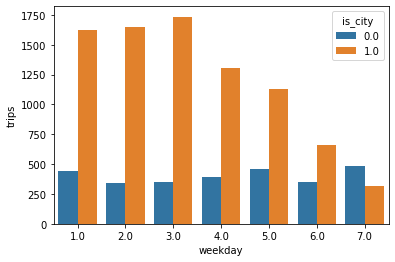

In [34]:
# Weekday distribution 1.1
rsv_wkd = (rsv
           .groupby(['weekday', 'is_city'])
           .agg(trips = ('ID viaje', 'count'))
           .reset_index()
          )
rsv_hr = (rsv
           .groupby(['hour', 'is_city'])
           .agg(trips = ('ID viaje', 'count'))
           .reset_index()
          )

sns.barplot(data= rsv_wkd, x = 'weekday', y= 'trips', hue= 'is_city')
plt.show()

<AxesSubplot:xlabel='hour', ylabel='trips'>

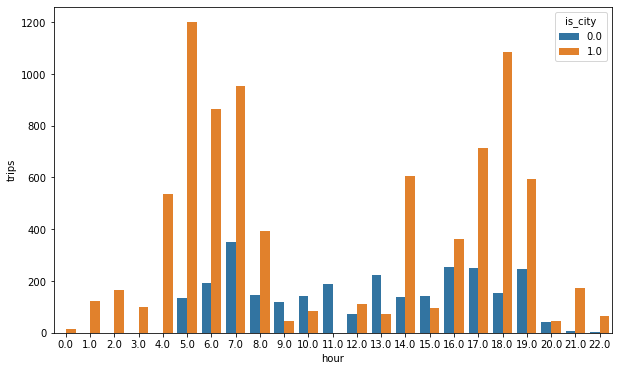

In [35]:
#Hour distribution 1.2
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data= rsv_hr, x = 'hour', y= 'trips', hue= 'is_city')

In [36]:
rsv_st = (rsv
          .filter(['hour', 'weekday','is_city','ID viaje', 'Costo total' ])
          .where(rsv['Costo total']!= 0)
    
          )
print(
rsv_st['Costo total'].where(rsv_st['is_city'] == 1).min(),
rsv_st['Costo total'].where(rsv_st['is_city'] == 1).max(),
rsv_st['Costo total'].where(rsv_st['is_city'] == 0).min(),
rsv_st['Costo total'].where(rsv_st['is_city'] == 0).max()
)

29.0 218.0 11.0 980.0


<AxesSubplot:xlabel='weekday', ylabel='hour'>

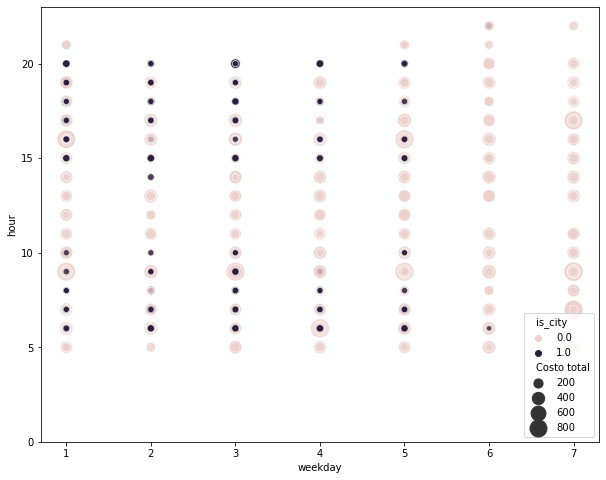

In [37]:
#Day and hour distribution with price per product 1.3
fig, ax = plt.subplots(figsize=(10,8))
ax.set(ylim=(0, 23))
ax.set_yscale('linear')
sns.scatterplot(data =rsv_st, x= 'weekday', y = 'hour', hue = 'is_city', alpha = 0.8, size = 'Costo total', sizes = (20,350))  

In [38]:
# B2B orders can happen on a saturday
rsv[(rsv.is_city == 1) & (rsv.weekday== 6) ]

,ID viaje,ruta,linea,fecha,weekday,week,hora,hour,ETA,eta_hour,...,numero_asientos,Costo total,Red discount,Coupon discount,Costo final,confirmed,Estación de subida,Estación de bajada,is_city,day_type
1756,498548,Cuautitlán Izcalli - SMO,Cuautitlán Izcalli - SMO,10/04/2021,6.0,15.0,06:12:00,6.0,06:40:00,6.0,...,1,29,7.0,0,22,False,Plaza San Marcos 2,Tlanepark acceso 1 (San Martín Obispo),1.0,weekend
1792,495750,G4S - Regreso,G4S Querétaro,03/04/2021,6.0,14.0,06:50:00,6.0,09:36:00,9.0,...,1,0,NaN,0,0,True,Equinix,IMSS,1.0,weekend
1796,501353,Elektra CEDIS - Buenavista Vuelta,Elektra - Villahermosa,10/04/2021,6.0,15.0,14:10:00,14.0,15:59:00,15.0,...,1,0,NaN,0,0,True,Elektra CEDIS - VHSA,La Paz,1.0,weekend
1797,490036,G4S - Ida,G4S Querétaro,27/03/2021,6.0,13.0,17:20:00,17.0,20:07:00,20.0,...,1,0,NaN,0,0,True,IMSS,Equinix,1.0,weekend
1814,495751,G4S - Ida,G4S Querétaro,03/04/2021,6.0,14.0,17:20:00,17.0,20:07:00,20.0,...,1,0,NaN,0,0,True,Hacienda la Cruz,Equinix,1.0,weekend
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10437,501646,Hyperion - Nicolás Romero Vuelta,Hyperion,10/04/2021,6.0,15.0,14:20:00,14.0,15:20:00,15.0,...,1,0,NaN,0,0,True,Hyperion,Soriana Nicolás Romero Regreso,1.0,weekend
10439,490036,G4S - Ida,G4S Querétaro,27/03/2021,6.0,13.0,17:20:00,17.0,20:07:00,20.0,...,1,0,NaN,0,0,True,IMSS,Equinix,1.0,weekend
10458,501383,Amazon MTY1 - Pesquería/Apodaca vuelta,Amazon MTY1 - Pesquería/Apodaca,10/04/2021,6.0,15.0,19:00:00,19.0,20:05:00,20.0,...,1,0,NaN,0,0,True,Almacén Apodaca 2,Cantoral,1.0,weekend
10465,495753,Elektra CEDIS - Villa Parrilla Ida,Elektra - Villahermosa,03/04/2021,6.0,14.0,05:15:00,5.0,05:50:00,5.0,...,1,0,NaN,0,0,True,Triunfo La Manga,Elektra CEDIS - VHSA,1.0,weekend


In [39]:
#Trips and price per hour Travel 2.1
travel_price_hour= (rsv[(rsv.is_city == 0) & (rsv['Costo total']!= 0)]
                    .groupby('hour')
                    .agg(avg_price = ('Costo total','mean'),trips = ('ID viaje', 'count'))
                    .assign(weight = lambda x: (x.trips /x.trips.sum())*100))
travel_price_hour

,avg_price,trips,weight
hour,,,
5.0,218.266667,135,4.831782
6.0,200.922280,193,6.907659
7.0,175.590909,352,12.598425
8.0,126.367647,136,4.867573
9.0,296.865546,119,4.259127
10.0,224.598592,142,5.082319
11.0,212.063158,190,6.800286
12.0,175.589041,73,2.612742
13.0,226.768889,225,8.052971


In [40]:
#Trips and price per hour City 2.2
city_price_hour = (rsv[(rsv.is_city == 1) & (rsv['Costo total']!= 0)]
 .groupby('hour')
 .agg(avg_price = ('Costo total','mean'),trips = ('ID viaje', 'count'))
 .assign(weight = lambda x: (x.trips /x.trips.sum())*100)
       )

city_price_hour


,avg_price,trips,weight
hour,,,
6.0,90.852941,170,6.533436
7.0,79.641558,770,29.592621
8.0,63.281046,306,11.760184
9.0,75.913043,46,1.767871
10.0,55.315789,19,0.730208
14.0,79.000000,12,0.461184
15.0,88.474227,97,3.727902
16.0,60.542857,245,9.415834
17.0,82.255725,262,10.069178


In [41]:
#Trips and price per day City 2.3
city_price_wkd = (rsv[(rsv.is_city == 1) & (rsv['Costo total']!= 0)]
 .groupby('weekday')
 .agg(avg_price = ('Costo total','mean'),trips = ('ID viaje', 'count'))
 .assign(weight = lambda x: (x.trips /x.trips.sum())*100)
       )

city_price_wkd

,avg_price,trips,weight
weekday,,,
1.0,77.985577,624,23.981553
2.0,74.001631,613,23.558801
3.0,75.310744,605,23.251345
4.0,75.933985,409,15.718678
5.0,73.925287,348,13.374327
6.0,48.333333,3,0.115296


In [42]:
#Trips and price per hour Travel 2.4
city_price_wkd = (
    rsv[(rsv.is_city == 0) & (rsv['Costo total']!= 0)]
    .groupby('weekday')
    .agg(avg_price = ('Costo total','mean'),trips = ('ID viaje', 'count'))
    .assign(weight = lambda x: (x.trips /x.trips.sum())*100)
       )

city_price_wkd

,avg_price,trips,weight
weekday,,,
1.0,183.510251,439,15.712241
2.0,167.896970,330,11.811024
3.0,171.404624,346,12.383679
4.0,205.578811,387,13.851110
5.0,201.571744,453,16.213314
6.0,223.286932,352,12.598425
7.0,242.956879,487,17.430208


## Answer
With the data seen so far.....
- City: Users have higher demand during weekdays specially in Monday, Tuesday and Wednesday, this three days account for **72%** of the week's demand *(Refer 1.1 and 2.3)*. The biggest amount of demand for this product happens on the morning peaks from 6 am to 9 am and also at 2 pm followed by the evening peak from 4 pm to 7 pm. Morning peak accounts for **48%** of daily demand while the evening peak has **43%** of the demand *(Refer to 1.2 and 2.2)*. City users are highly likely to be office workers, since their trip behaviour corresponds to office hours.

- Travel: Users have higher demand on Friday,Saturday and Sunday, this three days accounts for **45%** of the weekly demand *(Refer 1.1 and 2.4)*. This product demand is more stable across the day, but stil corresponds to Morning peak and evening peak has. *(Refer to 1.2 and 2.4)*. Since Travel is between states it is highly likely. 



# Dado el perfil que identificas, ¿qué ajustes harías en la oferta diponible o qué iniciativas propondrías para mejorar los resultados en cada una de las verticales?

In [43]:
#Geospatial exploration
map = KeplerGl()

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [44]:
sgs

,Id sugerencia,week,weekday,hour,Client_id,Latitud origen,Longitud origen,Latitud destino,Longitud destino
0,10652,15,7,23.0,409604.0,20.553563,-100.392255,19.288524,-99.622360
1,10651,15,7,23.0,409685.0,19.508680,-101.612018,19.987021,-101.280722
2,10650,15,7,23.0,409682.0,19.347770,-99.068340,18.924209,-99.221566
3,10649,15,7,22.0,404354.0,20.651450,-100.344020,19.355121,-99.276387
4,10648,15,7,22.0,389074.0,18.947916,-99.191668,18.946916,-99.190668
...,...,...,...,...,...,...,...,...,...
1062,9583,13,1,3.0,398733.0,19.378207,-99.148949,19.401534,-99.274351
1063,9582,13,1,3.0,398732.0,19.287475,-99.621562,20.619410,-100.439392
1064,9581,13,1,0.0,398610.0,19.516856,-99.190087,19.379300,-99.101770
1065,9580,13,1,0.0,397872.0,19.419920,-99.094400,19.306160,-99.210340


In [45]:
# add h3 to df
sgs['h3_origin']=[h3.geo_to_h3(x,y,7)for (x,y) in zip(sgs['Latitud origen'],sgs['Longitud origen'])]
sgs['h3_dest']=[h3.geo_to_h3(x,y,7)for (x,y) in zip(sgs['Latitud destino'],sgs['Longitud destino'])]
sgs

,Id sugerencia,week,weekday,hour,Client_id,Latitud origen,Longitud origen,Latitud destino,Longitud destino,h3_origin,h3_dest
0,10652,15,7,23.0,409604.0,20.553563,-100.392255,19.288524,-99.622360,874983d9dffffff,874986443ffffff
1,10651,15,7,23.0,409685.0,19.508680,-101.612018,19.987021,-101.280722,8749854eeffffff,874980328ffffff
2,10650,15,7,23.0,409682.0,19.347770,-99.068340,18.924209,-99.221566,8749958e8ffffff,8749b32e2ffffff
3,10649,15,7,22.0,404354.0,20.651450,-100.344020,19.355121,-99.276387,874983c86ffffff,874995b31ffffff
4,10648,15,7,22.0,389074.0,18.947916,-99.191668,18.946916,-99.190668,8749b32c6ffffff,8749b32c6ffffff
...,...,...,...,...,...,...,...,...,...,...,...
1062,9583,13,1,3.0,398733.0,19.378207,-99.148949,19.401534,-99.274351,874995ba6ffffff,874995b02ffffff
1063,9582,13,1,3.0,398732.0,19.287475,-99.621562,20.619410,-100.439392,874986443ffffff,874983c12ffffff
1064,9581,13,1,0.0,398610.0,19.516856,-99.190087,19.379300,-99.101770,874995b89ffffff,874995bb4ffffff
1065,9580,13,1,0.0,397872.0,19.419920,-99.094400,19.306160,-99.210340,874995bb3ffffff,87499586affffff


In [132]:
sgs_agg_origin=(sgs
                .groupby(['h3_origin', 'week', 'weekday'])
                .agg(sgs_cnt = ('Client_id', 'count'))
                .reset_index()
          )
sgs_agg_origin

,h3_origin,week,weekday,sgs_cnt
0,8729a4c01ffffff,13,3,1
1,8729a4c30ffffff,15,1,1
2,87450a1b6ffffff,15,6,1
3,87450a795ffffff,14,3,1
4,87450a795ffffff,15,6,1
...,...,...,...,...
899,876d34da6ffffff,14,7,1
900,876d34daaffffff,15,7,1
901,876d34dacffffff,14,3,1
902,876d35aa6ffffff,15,4,1


In [133]:
sgs_agg_dest=(sgs
              .groupby(['h3_dest', 'week', 'weekday'])
              .agg(sgs_cnt = ('Client_id', 'count'))
              .reset_index()
          )
sgs_agg_dest

,h3_dest,week,weekday,sgs_cnt
0,8729a4c00ffffff,13,3,1
1,8729a4c70ffffff,15,1,1
2,8729a4c75ffffff,14,3,1
3,87450a6b1ffffff,13,5,0
4,87450a6b1ffffff,13,7,1
...,...,...,...,...
854,876d34da6ffffff,14,6,1
855,876d35b11ffffff,14,1,1
856,876d35b11ffffff,14,3,1
857,876d35b11ffffff,15,1,1


In [134]:
map.add_data(data=sgs_agg_dest, name='destsgs')
map.add_data(data=sgs_agg_origin, name='originsgs')
map.add_data(data=sgs, name='sgs')
map.save_to_html()
map

Map saved to keplergl_map.html!


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ih5ou0k', 'type': …

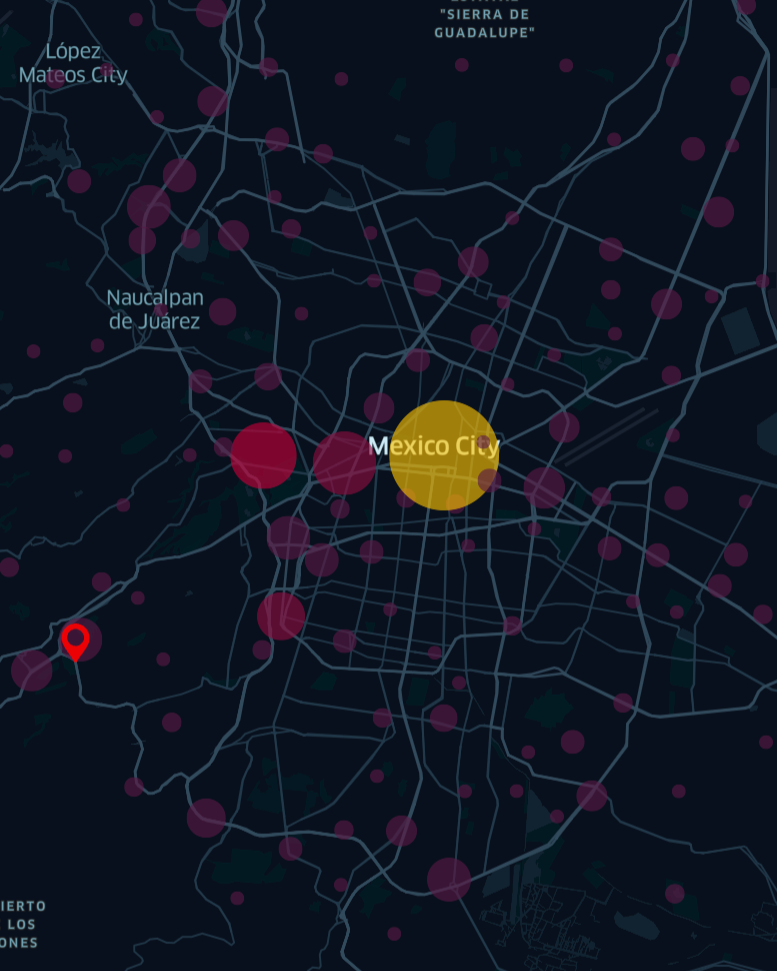 
## Demand origin cluster for CDMX 3.1
Santa fe is red icon

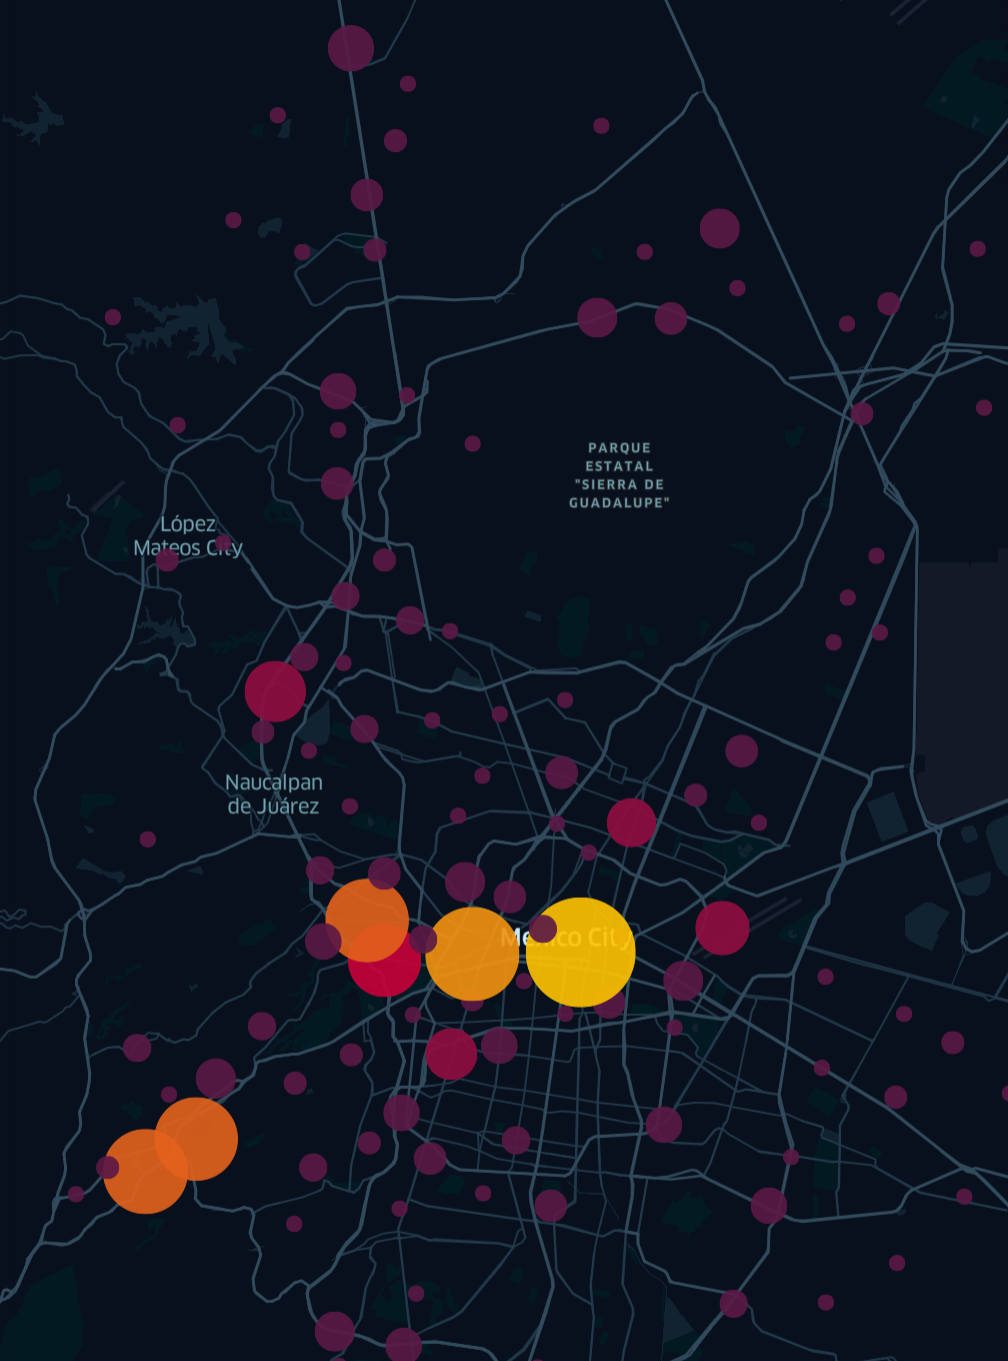
## Demand destination cluster for CDMX 3.4
Santa fe is red icon

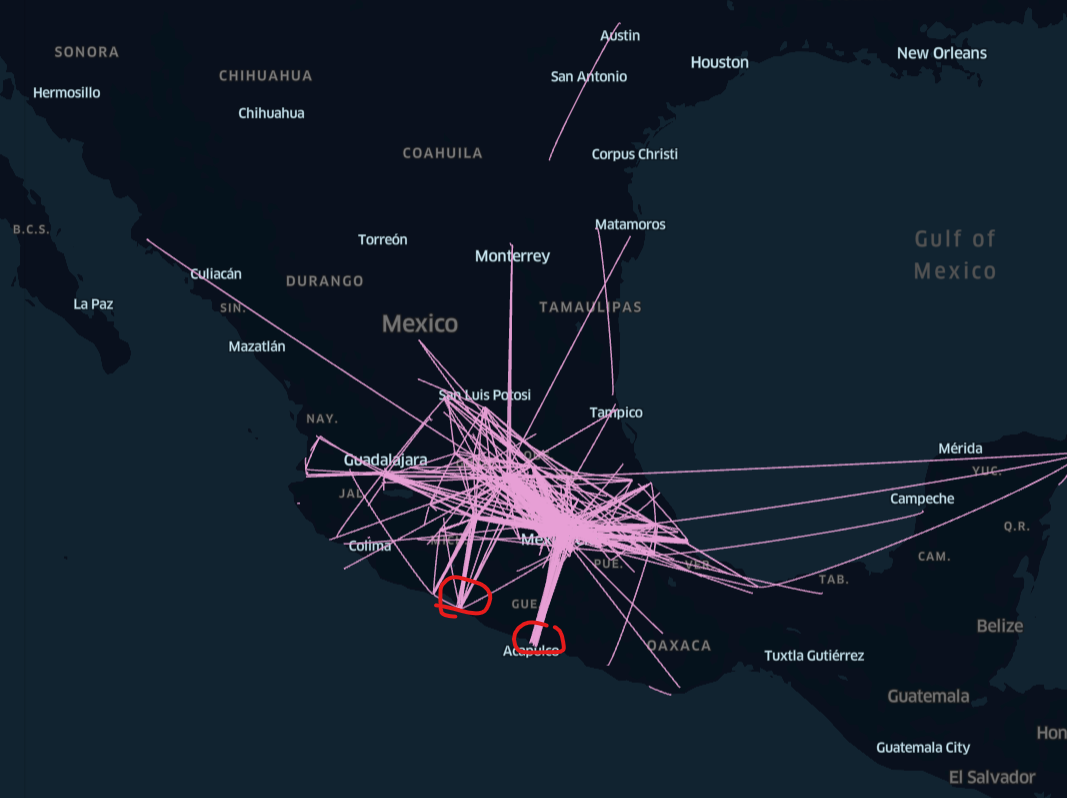
# Arc view 3.2
Interest in the pacific e.g. acapulco

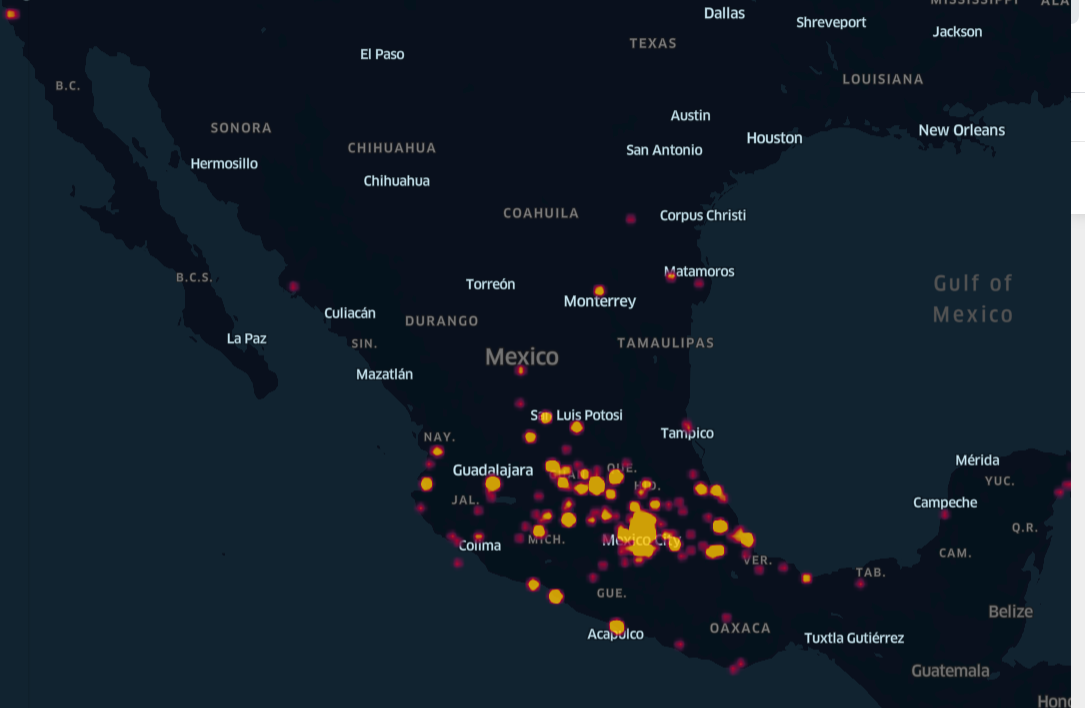
# Heatmap view 3.3
Middle part of the country is more penetrated

In [46]:
rsv_prep = rsv.filter(['id_usuario', 'is_city']).drop_duplicates()
#  Only 12 user id's have used both City and Travel

In [47]:
vans.head(
)

,Van,Ruta,Horario,hour,Inventario,Numero de Asientos por Van,Numero de Viajes,¿Viaje activo?
0,C04,Danone CLCN - Culiacán Ida,06:49:00,6.0,340,20,17,True
1,C04,Danone CLCN - Culiacán Ida,14:49:00,14.0,420,20,21,True
2,C04,Danone CLCN - Culiacán Ida,18:49:00,18.0,340,20,17,True
3,C04,Danone CLCN - Culiacán Vuelta,08:15:00,8.0,200,20,10,False
4,C04,Danone CLCN - Culiacán Vuelta,08:15:00,8.0,140,20,7,True


In [48]:
rsv.head()

,ID viaje,ruta,linea,fecha,weekday,week,hora,hour,ETA,eta_hour,...,numero_asientos,Costo total,Red discount,Coupon discount,Costo final,confirmed,Estación de subida,Estación de bajada,is_city,day_type
0,483896,Toluca - Santa Fe,Toluca - Santa Fe,22/03/2021,1.0,13.0,08:15:00,8.0,09:45:00,9.0,...,1,83,NaN,1,83,True,Lerma outlet,UP Santa Fe,0.0,weekday
1,496716,CDMX - Querétaro,Querétaro - CDMX,08/04/2021,4.0,15.0,13:00:00,13.0,16:40:00,16.0,...,1,185,NaN,50,185,True,Glorieta de la Palma,Walmart Juriquilla,0.0,weekday
2,495506,Querétaro - CDMX,Querétaro - CDMX,04/04/2021,7.0,14.0,17:10:00,17.0,20:42:00,20.0,...,2,390,NaN,50,390,True,Walmart Juriquilla,Glorieta de la Palma,0.0,weekend
3,490841,CDMX - Querétaro,Querétaro - CDMX,31/03/2021,3.0,14.0,10:30:00,10.0,14:06:00,14.0,...,2,420,NaN,50,420,True,Glorieta de la Palma,Walmart Juriquilla,0.0,weekday
4,490960,CDMX - Querétaro,Querétaro - CDMX,28/03/2021,7.0,13.0,19:15:00,19.0,22:46:00,22.0,...,2,420,NaN,50,420,True,Glorieta de la Palma,Puerta La Victoria,0.0,weekend


In [74]:
vans.rename({'Ruta': 'ruta'}, inplace = True)
vans

,Van,Ruta,Horario,hour,Inventario,Numero de Asientos por Van,Numero de Viajes,¿Viaje activo?
0,C04,Danone CLCN - Culiacán Ida,06:49:00,6.0,340,20,17,True
1,C04,Danone CLCN - Culiacán Ida,14:49:00,14.0,420,20,21,True
2,C04,Danone CLCN - Culiacán Ida,18:49:00,18.0,340,20,17,True
3,C04,Danone CLCN - Culiacán Vuelta,08:15:00,8.0,200,20,10,False
4,C04,Danone CLCN - Culiacán Vuelta,08:15:00,8.0,140,20,7,True
...,...,...,...,...,...,...,...,...
2374,VZ01,Amazon DVR1 - Ruta 2 Ida,02:00:00,2.0,180,20,9,True
2375,VZ01,Amazon DVR1 - Ruta 2 Vuelta,10:00:00,10.0,20,20,1,False
2376,VZ02,Amazon DVR1 - Ruta 1 Ida,01:00:00,1.0,420,20,21,True
2377,VZ02,Amazon DVR1 - Ruta 1 Vuelta,10:00:00,10.0,80,20,4,False


In [75]:
rsv.ruta.astype('str')
vans.Ruta.astype('str')
# rsv_join = vans.merge(rsv, how= 'left', on = 'ruta' )
# rsv_join

0         Danone CLCN - Culiacán  Ida
1         Danone CLCN - Culiacán  Ida
2         Danone CLCN - Culiacán  Ida
3       Danone CLCN - Culiacán Vuelta
4       Danone CLCN - Culiacán Vuelta
                    ...              
2374         Amazon DVR1 - Ruta 2 Ida
2375      Amazon DVR1 - Ruta 2 Vuelta
2376         Amazon DVR1 - Ruta 1 Ida
2377      Amazon DVR1 - Ruta 1 Vuelta
2378      Amazon DVR1 - Ruta 1 Vuelta
Name: Ruta, Length: 2379, dtype: object

In [117]:
# Demand per line
rsv_agg =( rsv
          .where(rsv['confirmed']==True)
          .groupby(['linea','is_city'])
          .agg(trips = ('ID viaje', 'count'))
          .reset_index()
         )
rsv_agg

,linea,is_city,trips
0,Aeropuerto - Santa Fe,1.0,63
1,Amazon DCL1,1.0,95
2,Amazon DGD2,1.0,88
3,Amazon DQR1,1.0,4
4,Amazon DVR1,1.0,348
5,Amazon MTY1 - Concordia,1.0,148
6,Amazon MTY1 - Guadalupe,1.0,275
7,Amazon MTY1 - Pesqueria,1.0,360
8,Amazon MTY1 - Pesquería/Apodaca,1.0,147
9,Amazon MTY1 - Zuazua,1.0,81


In [118]:
# Total inventory per line
vans_agg = (vans
            .where(vans['¿Viaje activo?'] == True)
            .groupby(['Ruta'])
            .agg(inventario = ('Inventario', 'sum'))
            .reset_index()
           )
vans_agg

,Ruta,inventario
0,Atramat Planta - Coyoacan Matut - Ida,208.0
1,Atramat Planta - Coyoacan Matut - Vta,208.0
2,Atramat Planta - Ecatepec Vesp - Ida,182.0
3,Atramat Planta - Ixtayopan Vesp - Ida,240.0
4,Atramat Planta - Iztapalap Vesp - Vta,260.0
...,...,...
394,Wolfmex - Ruta Alcanfores Vuelta,260.0
395,Wolfmex - Ruta Prados Ida,260.0
396,Wolfmex - Ruta Prados Vuelta,260.0
397,Zona Norte - Santa Fe,423.0


In [121]:
#Occupation per line
rsv_join = rsv_agg.merge(right = vans_agg, 
                         how= 'left', 
                         left_on = 'linea', 
                         right_on = 'Ruta'
                        )
rsv_join

,linea,is_city,trips,Ruta,inventario
0,Aeropuerto - Santa Fe,1.0,63,Aeropuerto - Santa Fe,364.0
1,Amazon DCL1,1.0,95,NaN,NaN
2,Amazon DGD2,1.0,88,NaN,NaN
3,Amazon DQR1,1.0,4,NaN,NaN
4,Amazon DVR1,1.0,348,NaN,NaN
5,Amazon MTY1 - Concordia,1.0,148,NaN,NaN
6,Amazon MTY1 - Guadalupe,1.0,275,NaN,NaN
7,Amazon MTY1 - Pesqueria,1.0,360,NaN,NaN
8,Amazon MTY1 - Pesquería/Apodaca,1.0,147,NaN,NaN
9,Amazon MTY1 - Zuazua,1.0,81,NaN,NaN


In [125]:
# occupatio  per product
utilization= (rsv_join
              .dropna()
              .assign(occupation = lambda x: x.trips / x.inventario)
             )
utilization_agg = (utilization
                   .groupby('is_city')
                   .agg(trips = ('trips','sum'), 
                        inventario = ('inventario','sum'))
                   .assign(occ = lambda x: x.trips/x.inventario)
                  )
utilization_agg

,trips,inventario,occ
is_city,,,
0.0,2069,4647.0,0.445233
1.0,2199,4269.0,0.515109


## Answer

Given the profiles identified and the utilization per product and per line I have reached to the next recommendations: 
- Recheck the utilization of the inventory per line. ¿Why some occupation rates are so low? Decrease the inventory available for those that have less than 50% of occupation. 
- Put some of that non used inventory in new routes. For example one in downtown where it is easily seen that the demand is highly concentrated. (3.1)
- Reduce inventory in non peak hours. To shift it towards peak hours. 


# ¿Qué línea nueva abrirías? ¿En qué días y a qué hora? ¿Con cuánto inventario? ¿Con qué precio?¿Con qué estaciones? ¿Por qué?

## Answer

1. Dowtown to outskirts: As seen in both images 3.1 and 3.4 that show the origin of demand cluster and destination of demand clusters. I say that the line show go from dowtown to naucalpan de juarez. The thing here is that the demand apparently comes from the same area but destination are more distributed along CDMX. **Open option from dowtown to naucalpan, with two station, the first one in fray servando teresa de mier (19.423180,	-99.12754) and the second in mundo E (19.524367,	-99.226956)** this line would follow and try to catch the same type of user as city, quickeness to their destinations is very appreciated. Since this are not workers from santa fe (usually are les price sensitive) pricing is something to be very careful of. Taking into consideration that the average price of public transport is 5 pesos, i would start with no more than 15 pesos the trip in order gather demand and start iterating from there. 


2. Option for Travel: There seems to be an interest on the beaches of the pacific (image 3.2 and 3.3). This type of destinations are normally filled with seasonality.The good thing about this is that we can open a route from CDMX(Polanco) - Acapulco(Diamante/Costera) only when it is high season (vacation) and taking inventory out from city product which will have less demand because of vacation, increasing utilization rate. The pricing benchmark for this would be against airplanes and buses. Needs to be cheaper than airlines and could be more expensive than buses since we carry less passengers and offer a better experience.  The  cost of the ticket would consider tolls, gas, maintenance, booking fee (urbvan income). 

# ¿Te hizo falta información para dar una respuesta mejor fundamentada en ambos incisos? ¿Cuál?

## Answer

Yes, maybe a more complete survey from non urbavn users, for example: 
- INEGI's Origen Destino data set. Where is people usually going to?  
- Population density per AGEB. Where the market is potentially bigger?
- avg Income or social economic status per AGEB. Who can pay for our service? 
- Public transportation penetration per municipality. Where is more difficult to access transport? 